# Add Metadata Properties to `FeedbackDataset`

In this part of our tutorial series for `FeedbackDatasets`, we will show how to use metadata properties to enhance the dataset. We will pull the dataset, add various metadata properties and upload it back. You can have a look at the previous tutorials for [creating the dataset](./create-dataset-001.ipynb) and [configuring the users and workspaces](./configure-users-and-workspaces-000.ipynb). Feel free to check out the [practical guides](../../../../practical_guides/practical_guides.md) page for more in-depth information.

Utilizing metadata properties is an effective means of enriching your dataset, enabling [effective filtering and sorting](./filter-and-query-008.ipynb). They are the pieces of information for each record that are accessible both in the UI and via SDK. Argilla provides various types of metadata properties, allowing you to tailor their use based on the requirements of your specific project. 

![workflow](../../../../_static/tutorials/end2end/base/workflow_metadata.svg)

## Table of Contents

1. [Load a FeedbackDataset](#Pull-the-Dataset)
   1. [From Argilla](#From-Argilla) 
   2. [From the HuggingFace Hub](#From-HuggingFace-Hub)
2. [Add metadata properties](#Add-Metadata-Properties)
    1. [TermsMetadataProperty](#TermsMetadataProperty)
    2. [IntegerMetadataProperty](#IntegerMetadataProperty)
    3. [FloatMetadataProperty](#FloatMetadataProperty)
3. [Filter and Sort by Metadata](#Filter-and-Sort-by-Metadata)
4. [Push the dataset](#Push-the-Dataset)
    1. [To Argilla](#To-Argilla)
    2. [To HuggingFace Hub](#To-HuggingFace-Hub)
5. [Conclusion](#Conclusion)

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

**Deploy Argilla on Hugging Face Spaces:** If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).

**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../../../getting_started/quickstart.md). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip

This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

First, let's install our dependencies and import the necessary libraries:

In [ ]:
!pip install argilla
!pip install datasets

In [1]:
import argilla as rg
from argilla._constants import DEFAULT_API_KEY
import statistics
import random

In order to run this notebook we will need some credentials to push and load datasets from `Argilla` and `🤗 Hub`, let's set them in the following cell:

In [3]:
# Argilla credentials
api_url = "http://localhost:6900"  # "https://<YOUR-HF-SPACE>.hf.space"
api_key = DEFAULT_API_KEY  # admin.apikey
# Huggingface credentials
hf_token = "hf_..."

Log in to argilla:

In [ ]:
rg.init(api_url=api_url, api_key=api_key)

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Pull the Dataset

As we uploaded the dataset we created in the [previous tutorial](./create-dataset-001.ipynb) to both Argilla and HuggingFace Hub, we can pull the dataset from either of them. Let us see how we can pull the dataset from both.

### From Argilla

We can pull the dataset from Argilla by using the `from_argilla` method. 

In [5]:
dataset_remote = rg.FeedbackDataset.from_argilla("end2end_textclassification")

### From HuggingFace Hub

We can also pull the dataset from HuggingFace Hub. Similarly, we can use the `from_huggingface` method to pull the dataset.

In [ ]:
dataset = rg.FeedbackDataset.from_huggingface("argilla/end2end_textclassification")

<div class="alert alert-info">

Note 

The dataset pulled from HuggingFace Hub is an instance of `FeedbackDataset` whereas the dataset pulled from Argilla is an instance of `RemoteFeedbackDataset`. The difference between the two is that the former is a local one and the changes made on it stay locally. On the other hand, the latter is a remote one and the changes made on it are directly reflected on the dataset on the Argilla server, which can make your process faster.

</div>

Let us briefly examine what our dataset looks like. It is a dataset that consists of data items with the field `text` that is yet to be annotated.

In [7]:
dataset[0].fields

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}

## Add Metadata Properties

Metadata properties are a great way to enhance the dataset for filtering and sorting, both in the UI and SDK. Argilla offers different types of metadata properties that you can make use of according to your needs for the specific project you are working on. For more information on metadata properties, please check out the [documentation](../../../../practical_guides/create_update_dataset/metadata.md).

### TermsMetadataProperty

The `TermsMetadataProperty` is a metadata property that can be used to filter the metadata of a record based on a list of possible terms or values.

In [8]:
terms_metadata_property = rg.TermsMetadataProperty(
    name="group", title="Annotation Group", values=["group-1", "group-2", "group-3"]
)

Note that the `name` will be the name of the metadata property shown internally. `title` is again the name of the metadata property displayed in the UI. `values` will be the list of possible values for the metadata property. To add it to the dataset, we can simply use the `add_metadata_property` method.

In [9]:
dataset.add_metadata_property(terms_metadata_property)
dataset_remote.add_metadata_property(terms_metadata_property)

TermsMetadataProperty(name='group', title='Annotation Group', visible_for_annotators=True, type='terms', values=['group-1', 'group-2', 'group-3'])

Let us add the metadata to individual records as well. For demonstration purposes here, we can create a list of groups and randomly select one to assign to each record. As we normally do, we should be careful to divide records into groups in equal numbers.

We firstly learn how many records we have in the dataset and how many groups we have defined in our `TermsMetadataProperty`. Then, we compile a list of group names, whose length is equivalent to the number of records.

In [ ]:
length_dataset = len(dataset)
num_groups = len(terms_metadata_property.values)

groups = [
    f"group-{i}"
    for i in range(1, num_groups + 1)
    for _ in range(
        length_dataset // num_groups + (1 if i <= length_dataset % num_groups else 0)
    )
]
groups_local = groups.copy()

Finally, we choose one group name randomly, assign it to the record and remove it from the list.

The adding process slightly differs among the `FeedbackDataset` and `RemoteFeedbackDataset`. For the former, we can simply add metadata by assigning the value. For the latter, we should use the `update_records` method. Let us see how we can do it for both.

In [10]:
# For the local dataset
for record in dataset.records:
    random_record = random.choice(groups_local)
    record.metadata["group"] = random_record
    groups_local.remove(random_record)

In [ ]:
# For the remote dataset (if you run the previous cell, you should create the groups again)
modified_records = [record for record in dataset_remote.records]

for record in modified_records:
    random_record = random.choice(groups)
    record.metadata["group"] = random_record
    groups.remove(random_record)

dataset_remote.update_records(modified_records)

#### Aggregate Metadata Values

In addition, we have the opportunity to add multiple metadata values for the `TermsMetadataProperty` to a single record. This is quite useful when a record falls into multiple categories. For the example case at hand, let us imagine that one of the records (or any number of them) is to be annotated by two groups. We can simply encode this information by giving a list of the metadata values. Let us see how it is done for the local `FeedbackDataset` and it is just the same process for the `RemoteFeedbackDataset` as above.

In [ ]:
dataset[1].metadata["group"] = ["group-1", "group-2"]

We have seen an example of how to add aggregate metadata values for `TermsMetadataProperty` here. Please note that this is also applicable for `IntegerMetadataProperty` and `FloatMetadataProperty`, and you can add them in the same way.

### IntegerMetadataProperty
The second type of metadata property that Argilla offers is the `IntegerMetadataProperty`, which can be used to filter the metadata of a record based on a range of integer values. While the `name` and `title` are the same as the `TermsMetadataProperty`, we do not have a `values` parameter. Instead, we have `min` and `max` parameters that define the range of the integer values. Let us create an `IntegerMetadataProperty` and add it to our dataset.

A metadata property that consists of the longest and shortest data items in our list would be useful for us. To add this, let us first find out what the longest and shortest data items are.

In [16]:
item_list = [items.fields["text"] for items in dataset]
max_length_string = len(max(item_list, key=len))
min_length_string = len(min(item_list, key=len))

We can now create our metadata property for item length with the shortest and longest data item lengths and add it to our dataset.

In [17]:
integer_metadata_property = rg.IntegerMetadataProperty(
    name="length",
    title="Length of the text",
    min=min_length_string,
    max=max_length_string,
)

dataset.add_metadata_property(integer_metadata_property)
dataset_remote.add_metadata_property(integer_metadata_property)

IntegerMetadataProperty(name='length', title='Length of the text', visible_for_annotators=True, type='integer', min=100, max=862)

Let us add the metadata to individual records. We will be adding the length of the data item to the metadata of each record. Again, we do it differently for `FeedbackDataset` and `RemoteFeedbackDataset`.

In [18]:
# For local dataset
for record in dataset.records:
    record.metadata["length"] = len(record.fields["text"])

In [19]:
# For remote dataset
modified_records = [record for record in dataset_remote.records]

for record in modified_records:
    record.metadata["length"] = len(record.fields["text"])

dataset_remote.update_records(modified_records)

### FloatMetadataProperty

The third and last type of metadata property that we can employ for our datasets is the `FloatMetadataProperty`. This metadata property can be used to filter the metadata of a record based on a range of float values. The `name` and `title` parameters are the same as the other metadata properties. Similar to the `IntegerMetadataProperty`, we have `min` and `max` parameters that define the range of the float values. 

While working with text data, we might want to evaluate the text length and filter our dataset by item lengths. For this purpose, we can make use of the standard deviation of item lengths along with the mean item length. With them, we can keep or work on the items whose lengths are between a certain standard deviation from the mean. We can create a `FloatMetadataProperty` with the min value as the mean minus the standard deviation and the max value as the mean plus the standard deviation. Let us first calculate the mean and standard deviation of the item lengths.

In [20]:
item_len_list = [len(items.fields["text"]) for items in dataset]
std = round(statistics.stdev(item_len_list), 3)
mean = statistics.mean(item_len_list)

Now that we know what the mean and standard deviation of the item lengths are, let us create a `FloatMetadataProperty` and add it to our dataset.

In [21]:
float_metadata_property = rg.FloatMetadataProperty(
    name="length_std",
    title="Standard deviation of the length of the text",
    min=mean - std,
    max=mean + std,
)

dataset.add_metadata_property(float_metadata_property)
dataset_remote.add_metadata_property(float_metadata_property)

FloatMetadataProperty(name='length_std', title='Standard deviation of the length of the text', visible_for_annotators=True, type='float', min=139.096, max=361.398)

Now that we have the float metadata property added to our dataset, let us add the metadata to individual records. We will be again adding the length of the data item. However, this time, we will add it as a float and only to the records whose lengths are between the mean minus the standard deviation and the mean plus the standard deviation. Let us see how we can do it for both `FeedbackDataset` and `RemoteFeedbackDataset`.

In [22]:
# For local dataset
for record in dataset.records:
    record_len = float(len(record.fields["text"]))
    if record_len <= mean + std and record_len >= mean - std:
        record.metadata["length_std"] = record_len

In [23]:
# For remote dataset
modified_records = [record for record in dataset_remote.records]

for record in modified_records:
    record_len = float(len(record.fields["text"]))
    if record_len <= mean + std and record_len >= mean - std:
        record.metadata["length_std"] = record_len

dataset.update_records(modified_records)

The resulting dataset is now a dataset with metadata properties that can be used for filtering and sorting.

In [24]:
dataset

FeedbackDataset(
   fields=[TextField(name='text', title='Text', required=True, type=<FieldTypes.text: 'text'>, use_markdown=False)]
   questions=[LabelQuestion(name='label', title='Label', description=None, required=True, type=<QuestionTypes.label_selection: 'label_selection'>, labels=['World', 'Sports', 'Business', 'Sci/Tech'], visible_labels=None)]
   guidelines=Classify the articles into one of the four categories.)
   metadata_properties=[TermsMetadataProperty(name='group', title='Annotation Group', visible_for_annotators=True, type='terms', values=['group-1', 'group-2', 'group-3']), IntegerMetadataProperty(name='length', title='Length of the text', visible_for_annotators=True, type='integer', min=100, max=862), FloatMetadataProperty(name='length_std', title='Standard deviation of the length of the text', visible_for_annotators=True, type='float', min=139.096, max=361.398)])
)

In [ ]:
dataset_remote

## Filter and Sort by Metadata

The UI allow us to filter using the metadata properties and combine the needed filter. Below, you can see an example, where we filtered by our metadata `Annotation Group`, `Length of the text` and `Standard Deviation` properties, so that from the 1000 records, we only got 242. Note that if they were set to `visible_for_annotators=False`, it would only appear for users with the `admin` or `owner` role.

> This can also be very useful to assign records to your team members in a common workspace. Please refer to how to [assign records](./assign-records-002.ipynb) for more information.

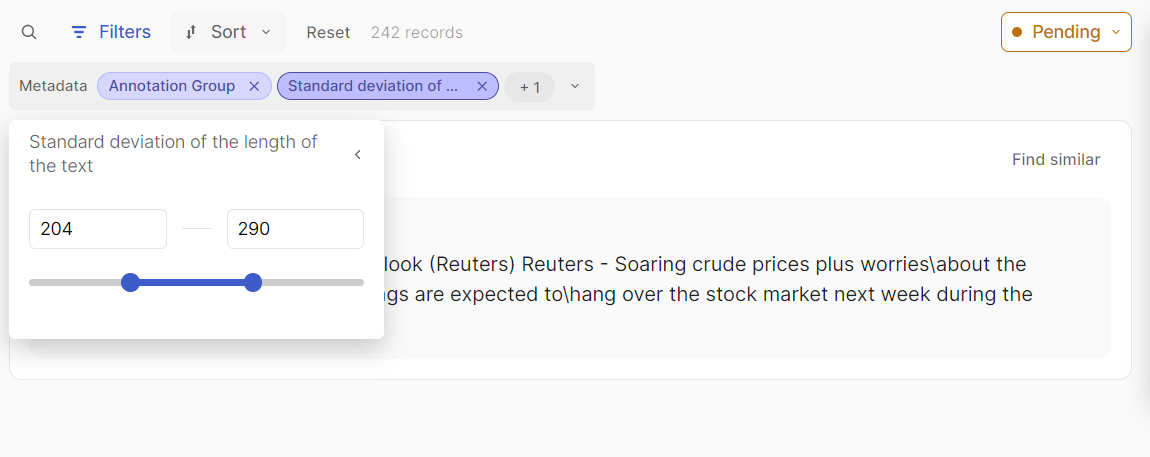

Now, we will make the same filtering but using the `filter_by` method provided in the Python SDK. Thus, we will will need to combine the three filters. In addition, each metadata is a different type, so we will need to use `TermsMetadataFilter` for the annotation group, `IntegerMetadataFilter` for the length of the text, and  `FloatMetadataFilter` for the standard deviation. We will be using the following parameters:

|       | Description      |  TermsMetadataFilter    |  IntegerMetadataFilter    |  FloatMetadataFilter    |
|-------|-------|-------|-------|-------|
|  *name*    | name of the metadata property      | group  | length  | length_std  |
|  *ge*   | values greater than or equal      | no-required  | 0  |  204     |
|  *le*    | values lower than or equal      |  no-required     | 282      |  290     |
|  *values*    |  values searched     |  group-1  and group-2   |  no-required     |  no-required     |

>  In the case of Integer and Float filters at least one of `ge` or `le` should be provided.

In [ ]:
filtered_records = dataset_remote.filter_by(
    metadata_filters=[
        rg.TermsMetadataFilter(
            name="group",
            values=["group-1", "group-2"]
        ),
        rg.IntegerMetadataFilter(
            name="length",
            le=282
        ),
        rg.FloatMetadataFilter(
            name="length_std",
            ge=204, 
            le=290
        ),  
    ]
)

print(len(filtered_records))

242


Now, we can also sort them by the metadata properties and when they were updated.

In [ ]:
from argilla import SortBy

filtered_dataset = dataset_remote.filter_by(
    metadata_filters=[
        rg.TermsMetadataFilter(
            name="group",
            values=["group-1", "group-2"]
        ),
        rg.IntegerMetadataFilter(
            name="length",
            le=282
        ),
        rg.FloatMetadataFilter(
            name="length_std",
            ge=204, 
            le=290
        ),
    ],
    response_status=["discarded"]
).sort_by(
    [
        SortBy(field="updated_at", order="desc"),
        SortBy(field="metadata.group", order="asc")
    ]
)

## Push the Dataset

We have now enhanced our dataset in terms of metadata properties and we can push it again. Note that you do not have to upload the improved version of the dataset to Argilla again. As you can see on your Argilla UI, the dataset already has the metadata properties we added.

### To Argilla

If you have opted to pull the dataset from HuggingFace and want to push to Argilla, you can simply use the `push_to_argilla` method.

In [ ]:
try:
    remote_dataset = rg.FeedbackDataset.from_argilla("end2end_textclassification_with_metadata")
    remote_dataset.delete()
except:
    pass
remote_dataset = dataset.push_to_argilla("end2end_textclassification_with_metadata")
remote_dataset

Now we can see that the dataset on Argilla has the metadata properties we added.

![Screenshot of Argilla UI](../../../../_static/tutorials/end2end/text-classification/argilla-ui-page-metadata.png)

### To HuggingFace Hub

If you have opted to pull the dataset from HuggingFace Hub, you can push the dataset to HuggingFace Hub by using the `push_to_huggingface` method. Do not forget to create a model card as well, which will make the dataset more readable and understandable for the users.

To be able to upload your dataset to the Hub, you must be logged in to the Hub. The following cell will log us with our previous token.

If we don't have one already, we can obtain it from [here](https://huggingface.co/docs/hub/security-tokens) (remember to set the write access).

In [ ]:
from huggingface_hub import login

login(token=hf_token)

We only need to call the `push_to_huggingface` method to push the dataset to HuggingFace Hub. If we have a dataset with the same name on the Hub, this method will update the existing one.

In [ ]:
#papermill_description=push-dataset-to-huggingface 
dataset.push_to_huggingface("argilla/end2end_textclassification_with_metadata", generate_card=True)

## Conclusion

In this tutorial, we have seen how to use metadata properties to enhance our dataset. We have first seen how we can pull the dataset from either Argilla or HuggingFace Hub. Then, we have seen how to add `TermsMetadataProperty`, `IntegerMetadataProperty` and `FloatMetadataProperty` to our dataset, and use them to filter and sort. We have also seen how `RemoteFeedbackDataset` works and how to push the dataset to HuggingFace Hub. To add vector representations of records in order for semantic search, you can checkout the [next tutorial](./add-vectors-004.ipynb). For more detailed info on how to utilize various tools, please refer to our [practical guides](../../../../practical_guides/practical_guides.md).